図形の検出
===


今回はOpenCVを用いて画像中から図形を検出する。図形の検出は、画像からのエッジの情報を取り出す処理と、エッジ情報を元に境界線を認識する処理、境界線から図形の形状を分類する処理の三つに分けられる。

今回は以下の単純な図形が描かれた画像を題材に、図形の検出方法について紹介する。

```{image} ../../Images/figures.png
:align: center
:width: 80%
```

## エッジの検出

[「OpenCVの基本」](edge-detection)で、紹介したように、画像からエッジの情報を得るアルゴリズムにはSobelフィルタやCannyフィルタがある。

これらのフィルタを画像に適用した後、候補となる画素の中で勾配が一定以上となる場所を閾値処理により取り出す二値化処理を施すことで、最終的なエッジが得られる。

以下がOpenCVでSobelフィルタとCanny法によりエッジ画像を得るプログラムと、その結果である。なお、Cannyフィルタは直接、二値画像を出力するため、二値化の処理はSobelフィルタの結果だけに適用している。

In [33]:
import cv2
import numpy as np

# 画像の読み込み
image = cv2.imread("../../Images/figures.png", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 画像をグレースケールにする
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Sobelフィルタ
dx = cv2.Sobel(gray, cv2.CV_8U, 1, 0)
dy = cv2.Sobel(gray, cv2.CV_8U, 0, 1)
sobel = np.sqrt(dx * dx + dy * dy)
sobel = (sobel - sobel.min()) / (sobel.max() - sobel.min())
sobel = (sobel * 255.0).astype("uint8")
_, sobel = cv2.threshold(sobel, 10, 255, cv2.THRESH_BINARY)

# Canny法
canny = cv2.Canny(gray, 100, 200)

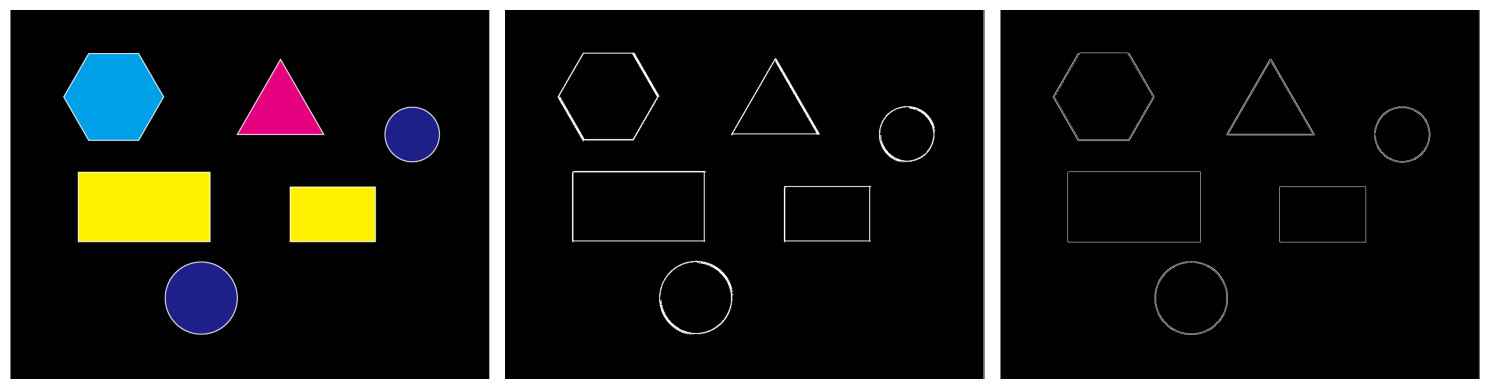

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.imshow(image)
ax.axis("off")

ax = fig.add_subplot(132)
ax.imshow(sobel, cmap="gray")
ax.axis("off")

ax = fig.add_subplot(133)
ax.imshow(canny, cmap="gray")
ax.axis("off")

plt.tight_layout()
plt.show()

### エッジの統合

結果を見てもらうと分かる通り、上記の入力画像は図形の輪郭線が幅を持っており、そのせいでエッジが二重線になっていることが分かる。もちろん、これはこれで間違いとは言えないのだが、今回のケースではエッジが内側の線と外側の線の間で曖昧に検出されており、この後の輪郭線検出に影響を及ぼす可能性がある。この問題は自然画像を入力とする場合には、より顕著となる。

そこで、輪郭線を抽出する前に、モルフォロジー演算によりエッジの統合を行っておく。モルフォロジー演算は一般的には二値画像を入力として、白色の領域を広げたり狭めたりする操作である(モルフォロジー演算の数学的な意味とは解釈が異なるので注意)。今回は白色領域を広げる処理であるdilationと白色領域を狭める処理であるerosionを連続して施すことでエッジの統合を行う。

モルフォロジー演算は構造要素と呼ばれる小さな画像のようなものを入力の二値画像にしたがって繰り返す操作に対応する。したがって、OpenCV(やMATLABなどの他のライブラリ)では、モルフォロジー演算の関数は二値画像と構造要素を引数にとる。OpenCVを用いる場合には、dilationとerosionはそれぞれ以下のようなコードで実現される。

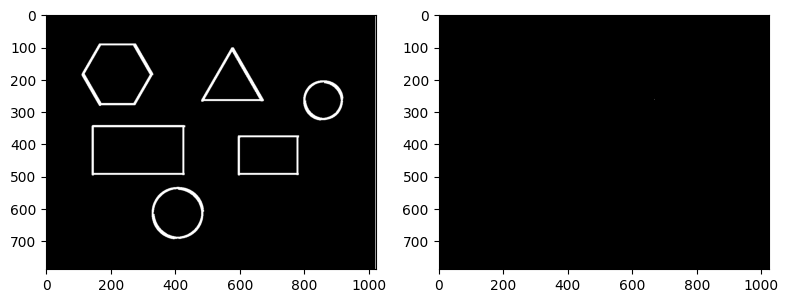

In [5]:
binary = sobel.copy()
res_dilate = cv2.dilate(binary, np.ones((5, 5), dtype=binary.dtype))
res_erode = cv2.erode(binary, np.ones((5, 5), dtype=binary.dtype))

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(res_dilate, cmap="gray")
ax = fig.add_subplot(122)
ax.imshow(res_erode, cmap="gray")
plt.tight_layout()
plt.show()

エッジを統合する場合、エッジが白色の領域に検出されているとすると、先にdilation、次にerosionの順序で処理を施す。dilationにより二重のエッジのそれぞれが太くなり、重なることで、太い1本のエッジとなる。その後、erosionをかけることで、そのエッジが細くなり、1本の細いエッジとなる。

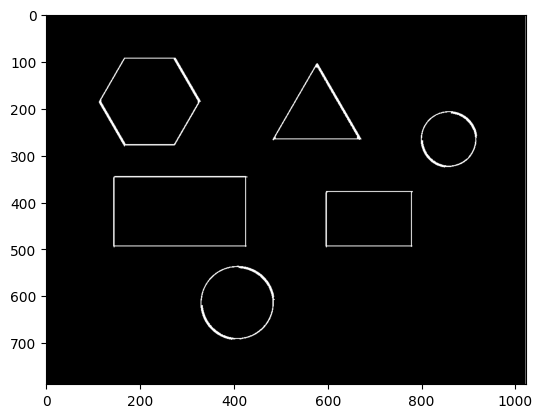

In [6]:
res = sobel.copy()
res = cv2.dilate(res, np.ones((5, 5), dtype=binary.dtype))
res = cv2.erode(res, np.ones((5, 5), dtype=binary.dtype))

plt.imshow(res, cmap="gray")
plt.show()

上記の結果の通り、dilationとerosionを組み合わせることで二本の細いエッジが一本のエッジに統合されていることが分かる。

なおdilationのあとにerosionをする操作をclosingとも呼び、以下のコードでも同じことができる。

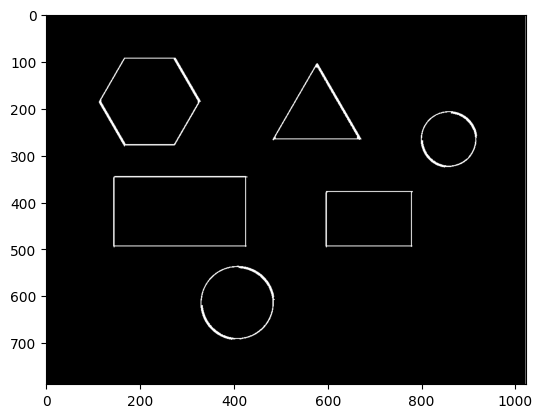

In [7]:
binary = sobel.copy()
res_close = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((5, 5), dtype=binary.dtype))

plt.imshow(res_close, cmap="gray")
plt.show()

### 輪郭線の検出

ここまでに検出したエッジの情報を使って輪郭線を抽出する。輪郭線の抽出にはOpenCVのfindContoursという関数を用いる。この関数には1985年にSuzukiさんとAbeさんという日本人が提案したアルゴリズムが実装されている(*1)。

(*1) S. Suzuki and K. Abe, “Topological structural analysis of digitized binary images by border following”, Computer Vision, Graphics and Image Processing”, 1985.

このアルゴリズムは二値画像(1がエッジで0が背景の色とする)をラスタスキャン (最初の列を左から右に見ていき、右端に到達したら、左から右に見ていく、以後繰り返し) していき、1が見つかったら、その画素から始まる輪郭線を追跡していく。

輪郭線の追跡はある画素の周りを時計回りに見ていき、初めて1となる画素にスキャン位置を移動する、という操作を繰り返すことで行われる。端点に到達するか、元の位置の画素に戻ってきたら、再びラスタスキャン順に値が1の画素で、まだどの輪郭にも含まれていない画素を探し、以後、同様の処理を繰り返していく。

OpenCVのfindContoursは3つの引数を取り、第1引数が入力の二値画像、第2引数が検出される輪郭線の階層関係、第3引数が抽出する輪郭線をどのように近似表現するかを表す。代表的な使い方は、

In [8]:
contours, _ = cv2.findContours(res_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

になる。cv2.RETR_EXTERNAL は二重丸のような階層的な輪郭線が現れたときに最も外側の閉曲線のみを抽出する。またcv2.CHAIN_APPROX_SIMPLEは抽出される輪郭線が水平方向、垂直方向、45度傾き, 135度の傾きに直線的につながるときに、それらを端点だけで近似する。

この他の使い方については公式のドキュメントを参考にしてほしい。

### 輪郭線の描画

上記の方法で検出された輪郭線はfindContoursと対になるdrawContoursという関数で描画できる。

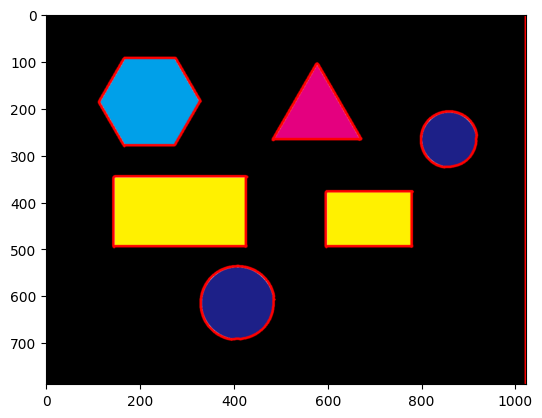

In [9]:
cv2.drawContours(image, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(image)
plt.show()

こちらも詳しい使い方は公式のドキュメントを参考にしてほしい。

実際に上記の方法で検出した輪郭線を描画してみたものが以下である。見ての通り、各図形の外側と画像自体の輪郭に輪郭線が検出されていることがわかる。

### 輪郭線の分類

各輪郭線がどのような図形か(円か？多角形か？そうなら何角形か？)を判別するには、輪郭線を多角形として近似して、その時の角の数を調べればいい。

上記の通り、findContoursで検出された輪郭線(cv2.CHAIN_APPROX_SIMPLEを使った場合)は特定の向きの直線のみを端点で近似している。そのため、現在検出されている多角形は、必ずしも角の点だけで表されているわけではない (contours[i]の長さを見てみると分かる)。

そこで、検出されている輪郭線を更に粗く角の点だけで近似することを考える。これにはOpenCVのcv2.approxPolyDPという関数が使える。この関数にはRamer-Douglas-Peucker法というアルゴリズムが使われている。

このアルゴリズムは、ある図形を適当な離散点(開曲線なら端点)を選んでその間を直線で結んだときに、最も離れている点を順次追加してポリライン(直線を結んで曲線を近似したもの)を更新していく。最も離れた点までの距離が一定以下になったら処理を終える。閉曲線の場合には、すべての候補となる点の中で最も離れた2点を見つけ、その二点を直線で結んで、二点の上部と下部を別々のポリラインで近似する。

それではcv2.findContoursで検出した各輪郭線についてcv2.approxPolyDPを用いて近似してみる。

In [10]:
for i, cnt in enumerate(contours):
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    # 輪郭線の近似
    approx = cv2.approxPolyDP(cnt, 0.01 * arclen, True)
    # 何角形かを見てみる
    print("Figure #{:d} has {:2d} corners!".format(i + 1, len(approx)))
    # 輪郭線の描画
    cv2.drawContours(image, [approx], -1, (255, 0, 0), 3, cv2.LINE_AA)

Figure #1 has 13 corners!
Figure #2 has  4 corners!
Figure #3 has  4 corners!
Figure #4 has 15 corners!
Figure #5 has  3 corners!
Figure #6 has  6 corners!
Figure #7 has  2 corners!


上記のコードではcv2.arcLengthを使って曲線の長さを計算し、その長さの100分の1の精度を持つように輪郭線を近似している。この精度はあまり細かすぎると角が増え、粗過ぎても角が減ってしまうので、多少の調整が必要ではある。printで出力された内容を見てみると6や4といった角の数と思われる数字が得られていることが分かる。

角の数が正しく得られていることが分かったら、その角の数に基づいて、画像中にラベルを入れてみよう。OpenCVでテキストを画像中に入れるにはcv2.putTextを使う。ラベルを入れるコードは例えば次のようになるだろう。

In [11]:
n_gon = len(approx)
text = "unknown"
if n_gon > 10:
    text = "circle"
elif n_gon == 6:
    text = "hexagon"
elif n_gon == 5:
    text = "pentagon"
elif n_gon == 4:
    text = "rectangle"
elif n_gon == 3:
    text = "triangle"

In [12]:
result = image.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

for cnt in contours:
    arclen = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, arclen * 1.0e-2, True)
    cv2.drawContours(result, [approx], -1, (255, 0, 0), 3)

    n_gon = len(approx)
    text = "unknown"
    if n_gon > 10:
        text = "circle"
    elif n_gon == 6:
        text = "hexagon"
    elif n_gon == 5:
        text = "pentagon"
    elif n_gon == 4:
        text = "rectangle"
    elif n_gon == 3:
        text = "triangle"

    position = np.asarray(approx).reshape((-1, 2)).max(axis=0).astype("int32")
    px, py = position
    cv2.putText(result, text, (px + 10, py + 10), font, 1.0, (255, 255, 255), 2, cv2.LINE_AA)

正しくプログラムがかけていれば、以下のような画像が得られるはずである。

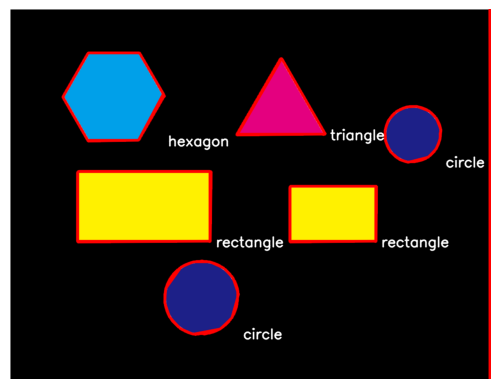

In [13]:
plt.imshow(result)
plt.axis("off")
plt.show()